In [1]:
import dotenv
import pendulum
from sqlalchemy import asc, cast
from sqlalchemy import create_engine, select, BigInteger
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, select, BigInteger
from config import Settings
from models import MessageSql
from pydantic import BaseModel, Field

class Glitch(BaseModel):
    FromGNodeAlias: str
    Node: str
    Type: str
    Summary: str
    Details: str
    CreatedMs: int
    TypeName: str
    Version: str

house_alias = "fir"
message_type = "glitch"
start_ms = pendulum.datetime(2025, 12, 20, 0, tz='America/New_York').timestamp()*1000
end_ms = pendulum.datetime(2026, 1, 10, 0, tz='America/New_York').timestamp()*1000

stmt = select(MessageSql).filter(
    MessageSql.message_type_name == message_type,
    MessageSql.from_alias == f"hw1.isone.me.versant.keene.{house_alias}.scada",
    MessageSql.message_persisted_ms <= cast(int(end_ms), BigInteger),
    MessageSql.message_persisted_ms >= cast(int(start_ms), BigInteger),
).order_by(asc(MessageSql.message_persisted_ms))

settings = Settings(_env_file=dotenv.find_dotenv())
engine = create_engine(settings.db_url_no_async.get_secret_value())
Session = sessionmaker(bind=engine)
session = Session()
result = session.execute(stmt)
messages = result.scalars().all()

print(f"Found {len(messages)} messages")


Found 155 messages


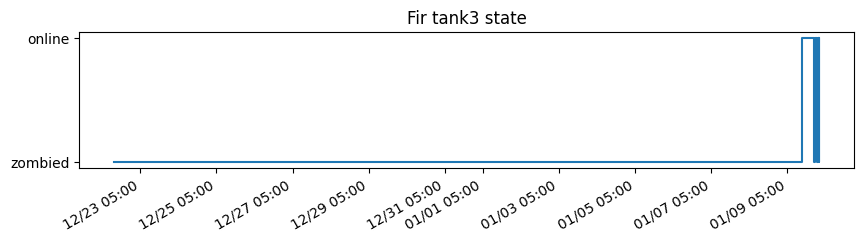

In [2]:
PRINT = False
times = []
online = []

for m in messages:
    glitch = Glitch(**m.payload)
    # print(glitch.Summary)
    # print(glitch.Details)

    if glitch.Summary == 'pico-just-zombied':
        if PRINT: print("Just zombied at", pendulum.from_timestamp(m.message_persisted_ms/1000, tz='America/New_York'))
        times.append(pendulum.from_timestamp(m.message_persisted_ms/1000, tz='America/New_York'))
        online.append(0)
    elif "[tank3] recovered from zombie state" in glitch.Details:
        if PRINT: print("Recovered from zombie state at", pendulum.from_timestamp(m.message_persisted_ms/1000, tz='America/New_York'))
        times.append(pendulum.from_timestamp(m.message_persisted_ms/1000, tz='America/New_York'))
        online.append(1)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 2))
plt.step(times, online, where='post')
plt.yticks([0, 1])
plt.gca().set_yticklabels(['zombied', 'online'])
plt.title(f'Fir tank3 state')
import matplotlib.dates as mdates

# Set the x-axis date format to 'mm/dd hh:00'
date_format = mdates.DateFormatter('%m/%d %H:00')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()

plt.show()